In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.duration.hazard_regression import PHReg
import matplotlib.pyplot as plt
import os
import pickle
import tempfile
from dataclasses import dataclass
from typing import Optional, Dict, Any, List, Union, Callable

In [5]:
class CensorWeightCalculator:
    """
    Calculates stabilized inverse probability of censoring weights (IPCW)
    for survival analysis.
    """
    def __init__(self, model_fitter, censor_event: str, pool_models: str = "none"):
        self.model_fitter = model_fitter
        self.censor_event = censor_event
        self.pool_models = pool_models

    def fit(self, data: pd.DataFrame, numerator_vars: List[str], 
            denominator_vars: List[str], id_col: str, period_col: str) -> pd.DataFrame:
        data_copy = data.copy()
        periods = sorted(data_copy[period_col].unique())
        weights_df = pd.DataFrame()

        # Fit pooled models if required
        pooled_num_model = self._fit_pooled_model(data_copy, numerator_vars) if self.pool_models in ["numerator", "both"] else None
        pooled_denom_model = self._fit_pooled_model(data_copy, denominator_vars) if self.pool_models in ["denominator", "both"] else None

        for period in periods:
            period_data = data_copy[data_copy[period_col] == period].copy()
            if len(period_data) == 0:
                continue

            period_data['is_censored'] = (period_data[self.censor_event] == 1).astype(int)

            if period_data['is_censored'].nunique() <= 1:
                period_data['weight'] = 1.0
            else:
                try:
                    # Numerator model
                    X_num = sm.add_constant(period_data[numerator_vars])
                    if self.pool_models != "numerator":
                        num_model = self.model_fitter(period_data['is_censored'], X_num).fit_regularized(alpha=0.01, disp=0)
                        num_probs = num_model.predict(X_num)
                    else:
                        num_probs = pooled_num_model.predict(X_num)

                    # Denominator model
                    X_denom = sm.add_constant(period_data[denominator_vars])
                    if self.pool_models != "denominator":
                        denom_model = self.model_fitter(period_data['is_censored'], X_denom).fit_regularized(alpha=0.01, disp=0)
                        denom_probs = denom_model.predict(X_denom)
                    else:
                        denom_probs = pooled_denom_model.predict(X_denom)

                    num_probs = np.clip(num_probs, 0.001, 0.999)
                    denom_probs = np.clip(denom_probs, 0.001, 0.999)
                    period_data['weight'] = (1 - num_probs) / (1 - denom_probs)

                except (np.linalg.LinAlgError, ValueError) as e:
                    print(f"Warning: Model fitting failed for period {period}. Setting weights to 1.0. Error: {e}")
                    period_data['weight'] = 1.0

            period_data['weight'] = period_data['weight'].fillna(1.0)
            period_data.loc[np.isinf(period_data['weight']), 'weight'] = 1.0
            
            # Winsorize weights at 99th percentile
            q99 = np.percentile(period_data['weight'], 99)
            period_data.loc[period_data['weight'] > q99, 'weight'] = q99

            weights_df = pd.concat([weights_df, period_data[[id_col, period_col, 'weight']]])

        return weights_df.reset_index(drop=True)

    def _fit_pooled_model(self, data: pd.DataFrame, vars_list: List[str]):
        data['is_censored'] = (data[self.censor_event] == 1).astype(int)

        if data['is_censored'].nunique() <= 1:
            return self.DummyModel(data['is_censored'].mean())

        try:
            X = sm.add_constant(data[vars_list])
            model = self.model_fitter(data['is_censored'], X).fit_regularized(alpha=0.01, disp=0)
            return model
        except (np.linalg.LinAlgError, ValueError) as e:
            print(f"Warning: Pooled model fitting failed. Returning DummyModel. Error: {e}")
            return self.DummyModel(data['is_censored'].mean())

    class DummyModel:
        def __init__(self, constant_prob):
            self.constant_prob = constant_prob

        def predict(self, X):
            return np.ones(len(X)) * self.constant_prob

class OutcomeModel:
    def __init__(self, adjustment_vars: Optional[List[str]] = None):
        self.adjustment_vars = adjustment_vars
        self.fitted_model = None
        self.model_info = None

    def fit(self, data: pd.DataFrame, id_col: str, time_col: str, 
            event_col: str, treatment_col: str, weight_col: str):
        model_data = data.copy()

        formula = f"{time_col} ~ {treatment_col}"
        if self.adjustment_vars:
            formula += " + " + " + ".join(self.adjustment_vars)

        model = PHReg.from_formula(
            formula,
            data=model_data,
            status=model_data[event_col],
            weights=model_data[weight_col]
        )
        result = model.fit()

        self.fitted_model = result
        self.model_info = {
            'model': model,
            'vcov': result.cov_params(),
            'formula': formula
        }
        return self

    def predict(self, data: pd.DataFrame, times: List[int]) -> Dict[str, Any]:
        if not self.fitted_model:
            raise ValueError("Model not fitted yet.")

        pred_data = data.copy()
        baseline_surv = self._estimate_baseline_survival(times)
        lp = self._calculate_linear_predictor(pred_data)
        survival = np.power(baseline_surv, np.exp(lp)[:, np.newaxis])
        ci_width = 1.96 * 0.1 * survival

        return {
            'times': times,
            'survival': survival,
            'lower': np.maximum(0, survival - ci_width),
            'upper': np.minimum(1, survival + ci_width)
        }

    def _estimate_baseline_survival(self, times: List[int]) -> np.ndarray:
        lambda_hat = 0.1
        return np.exp(-lambda_hat * np.array(times))

    def _calculate_linear_predictor(self, data: pd.DataFrame) -> np.ndarray:
        exog_names = self.fitted_model.model.exog_names
        X = pd.DataFrame(index=data.index)
        for name in exog_names:
            if name == 'Intercept':
                X[name] = 1
            else:
                X[name] = data[name]
        return X.values @ self.fitted_model.params

class StatsGlmLogit:
    def __init__(self, save_path: Optional[str] = None):
        self.save_path = save_path
        if save_path and not os.path.exists(save_path):
            os.makedirs(save_path)

    def fit(self, data: pd.DataFrame, treatment_col: str, numerator_vars: List[str],
            denominator_vars: List[str], id_col: str, period_col: str) -> pd.DataFrame:
        periods = sorted(data[period_col].unique())
        weights_df = pd.DataFrame()

        for period in periods[1:]:
            period_data = data[data[period_col] == period].copy()
            if len(period_data) == 0:
                continue

            prev_period = periods[periods.index(period) - 1]
            prev_data = data[data[period_col] == prev_period].copy()

            merged_data = pd.merge(
                period_data,
                prev_data[[id_col, treatment_col]],
                on=id_col,
                suffixes=('', '_prev')
            )

            merged_data['switched'] = (merged_data[treatment_col] != 
                                     merged_data[f"{treatment_col}_prev"]).astype(int)

            # Fit models
            X_num = sm.add_constant(merged_data[numerator_vars])
            num_model = sm.Logit(merged_data['switched'], X_num).fit(disp=0)

            X_denom = sm.add_constant(merged_data[denominator_vars])
            denom_model = sm.Logit(merged_data['switched'], X_denom).fit(disp=0)

            # Save models if path provided
            if self.save_path:
                for name, model in [("num", num_model), ("denom", denom_model)]:
                    with open(os.path.join(self.save_path, f"{name}_model_period_{period}.pkl"), 'wb') as f:
                        pickle.dump(model, f)

            # Calculate weights
            num_probs = num_model.predict(X_num)
            denom_probs = denom_model.predict(X_denom)
            merged_data['weight'] = num_probs / denom_probs
            merged_data['weight'] = merged_data['weight'].fillna(1.0)

            weights_df = pd.concat([weights_df, merged_data[[id_col, period_col, 'weight']]])

        return weights_df.reset_index(drop=True)

class TrialSequence:
    def __init__(self, estimand: str):
        self.estimand = estimand
        self.data = None
        self.id_col = None
        self.period_col = None
        self.treatment_col = None
        self.outcome_col = None
        self.eligible_col = None
        self.censor_calculator = None
        self.outcome_model = None
        self.switch_weight_model = None
        self.expansion = None

    def set_data(self, data: pd.DataFrame, id: str, period: str, treatment: str,
                 outcome: str, eligible: str):
        self.data = data.copy()
        self.id_col = id
        self.period_col = period
        self.treatment_col = treatment
        self.outcome_col = outcome
        self.eligible_col = eligible
        return self

    def set_censor_weight_model(self, censor_event: str, numerator: str,
                              denominator: str, pool_models: str, model_fitter):
        self.censor_calculator = CensorWeightCalculator(
            model_fitter=model_fitter,
            censor_event=censor_event,
            pool_models=pool_models
        )
        return self

    def set_switch_weight_model(self, numerator: str, denominator: str, model_fitter):
        self.switch_weight_model = model_fitter
        return self

    def set_outcome_model(self, adjustment_terms: Optional[str] = None):
        self.outcome_model = OutcomeModel(
            adjustment_vars=adjustment_terms.split(" + ") if adjustment_terms else None
        )
        return self

    def calculate_weights(self):
        if not all([self.data is not None, self.censor_calculator is not None]):
            raise ValueError("Data and censor calculator must be set before calculating weights")
        
        # Calculate censoring weights
        self.censor_weights = self.censor_calculator.fit(
            data=self.data,
            numerator_vars=['age'],
            denominator_vars=['age', self.treatment_col],
            id_col=self.id_col,
            period_col=self.period_col
        )
        
        if self.estimand == "PP" and self.switch_weight_model is not None:
            # Calculate switching weights for PP analysis
            self.switch_weights = self.switch_weight_model.fit(
                data=self.data,
                treatment_col=self.treatment_col,
                numerator_vars=['age'],
                denominator_vars=['age', 'x1', 'x3'],
                id_col=self.id_col,
                period_col=self.period_col
            )
            
            # Combine weights
            self.data = pd.merge(self.data, self.censor_weights, 
                               on=[self.id_col, self.period_col], how='left')
            self.data = pd.merge(self.data, self.switch_weights,
                               on=[self.id_col, self.period_col], how='left')
            self.data['final_weight'] = self.data['weight_x'] * self.data['weight_y']
        else:
            # For ITT, only use censoring weights
            self.data = pd.merge(self.data, self.censor_weights,
                               on=[self.id_col, self.period_col], how='left')
            self.data['final_weight'] = self.data['weight']
            
        return self

    def expand_trials(self):
        if self.data is None:
            raise ValueError("Data must be set before expanding trials")
            
        # Create expanded dataset
        expanded_data = []
        for period in sorted(self.data[self.period_col].unique()):
            period_data = self.data[self.data[self.period_col] == period].copy()
            period_data['trial_period'] = period
            expanded_data.append(period_data)
            
        self.expansion = pd.concat(expanded_data, ignore_index=True)
        return self

    def fit_msm(self, weight_cols: List[str], modify_weights=None):
        if self.expansion is None or self.outcome_model is None:
            raise ValueError("Must expand trials and set outcome model before fitting MSM")
            
        # Prepare weights
        if modify_weights:
            for col in weight_cols:
                self.expansion[col] = modify_weights(self.expansion[col])
                
        # Fit the model
        self.outcome_model.fit(
            data=self.expansion,
            id_col=self.id_col,
            time_col='time',
            event_col=self.outcome_col,
            treatment_col=self.treatment_col,
            weight_col='final_weight'
        )
        return self 

    def set_expansion_options(self, output: Callable[[pd.DataFrame], Any], chunk_size: int):
        self.expansion_output = output
        self.chunk_size = chunk_size
        return self

In [6]:
def load_and_prepare_data(file_path: str) -> pd.DataFrame:
    """Load and prepare the censored data."""
    data = pd.read_csv(file_path)
    print("Data shape:", data.shape)
    print("\nFirst few rows:")
    print(data.head())
    print("\nSummary statistics:")
    print(data.describe())
    return data

# Execute data loading
data_censored = load_and_prepare_data("data/data_censored.csv")

Data shape: (725, 12)

First few rows:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

Summary statistics:
               id      period   treatment          x1          x2          x3  \
count  725.000000  725.000000  725.000000  725.000000  725.000000  725.000000   
mean    49.278621    7.051034    0.467586    0.405517   -0.173552    0.486897   
std     28.119313    5.802351    0.499293    0.491331    0.997552    0.5

In [7]:
def setup_trial_sequences(data: pd.DataFrame) -> tuple:
    """Set up PP and ITT trial sequences."""
    # Create trial sequences
    trial_pp = TrialSequence(estimand="PP")
    trial_itt = TrialSequence(estimand="ITT")
    
    # Create directories
    trial_pp_dir = os.path.join(tempfile.gettempdir(), "trial_pp")
    trial_itt_dir = os.path.join(tempfile.gettempdir(), "trial_itt")
    os.makedirs(trial_pp_dir, exist_ok=True)
    os.makedirs(trial_itt_dir, exist_ok=True)
    
    # Set data
    for trial in [trial_pp, trial_itt]:
        trial.set_data(
            data=data,
            id="id",
            period="period",
            treatment="treatment",
            outcome="outcome",
            eligible="eligible"
        )
    
    print("Trial sequences initialized")
    return trial_pp, trial_itt, trial_pp_dir, trial_itt_dir

# Execute trial sequence setup
trial_pp, trial_itt, trial_pp_dir, trial_itt_dir = setup_trial_sequences(data_censored)

Trial sequences initialized


In [8]:
def show_weight_models(trial):
    if hasattr(trial, 'censor_weights'):
        print("Censor Weights:")
        print(trial.censor_weights.head())
    if hasattr(trial, 'switch_weights'):
        print("Switch Weights:")
        print(trial.switch_weights.head())

def setup_weight_models(trial_pp, trial_itt, pp_dir, itt_dir):
    """Set up weight models for both analyses."""
    # Instantiate model fitter for switching weights using StatsGlmLogit
    pp_switch_model_fitter = StatsGlmLogit(save_path=os.path.join(pp_dir, "switch_models"))
    
    # For censor weights, use a lambda that creates a statsmodels Logit model.
    # Adjust alpha, maxiter, or tol here if needed.
    pp_censor_model_fitter = lambda y, X: sm.Logit(y, X)
    itt_censor_model_fitter = lambda y, X: sm.Logit(y, X)
    
    # PP analysis weights
    trial_pp.set_switch_weight_model(
        numerator="x2",
        denominator="x2 + x1",
        model_fitter=pp_switch_model_fitter.fit
    )
    
    trial_pp.set_censor_weight_model(
        censor_event="censored",
        numerator="x2",
        denominator="x2 + x1",
        pool_models="none",
        model_fitter=pp_censor_model_fitter
    )
    
    # ITT analysis weights
    trial_itt.set_censor_weight_model(
        censor_event="censored",
        numerator="x2",
        denominator="x2 + x1",
        pool_models="numerator",
        model_fitter=itt_censor_model_fitter
    )
    
    trial_itt.calculate_weights()
    
    print("PP Analysis:")
    show_weight_models(trial_pp)
    print("\nITT Analysis:")
    show_weight_models(trial_itt)
    
    return trial_pp, trial_itt

# Execute weight model setup
trial_pp, trial_itt = setup_weight_models(trial_pp, trial_itt, trial_pp_dir, trial_itt_dir)

/opt/anaconda3/envs/data_analytics/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/opt/anaconda3/envs/data_analytics/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/envs/data_analytics/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/opt/anaconda3/envs/data_analytics/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common

PP Analysis:

ITT Analysis:
Censor Weights:
   id  period    weight
0   1       0  1.321050
1   2       0  1.197746
2   3       0  1.081146
3   4       0  1.141633
4   5       0  1.488303


In [9]:
def save_to_datatable():
    """Handler for saving expanded data to a data table."""
    def handler(data):
        return data
    return handler

def setup_and_expand_trials(trial_pp, trial_itt):
    """Set up outcome models and expand trials."""
    # Set outcome models
    trial_pp.set_outcome_model()
    trial_itt.set_outcome_model(adjustment_terms="x2")
    
    # Set expansion options for both trials
    for trial in [trial_pp, trial_itt]:
        trial.set_expansion_options(
            output=save_to_datatable(),
            chunk_size=500
        )
    
    # Expand trials
    trial_pp.expand_trials()
    trial_itt.expand_trials()
    
    # Add 'time' column to the ITT expansion (using period)
    trial_itt.expansion['time'] = trial_itt.expansion['period']
    
    # Fit MSM for ITT analysis with modified weights (capping at the 99th percentile)
    trial_itt.fit_msm(
        weight_cols=["weight"],
        modify_weights=lambda w: np.minimum(w, np.quantile(w, 0.99))
    )
    
    print("Trials expanded and models fitted")
    return trial_pp, trial_itt

# Execute trial expansion
trial_pp, trial_itt = setup_and_expand_trials(trial_pp, trial_itt)

Trials expanded and models fitted


In [10]:
def outcome_data(trial):
    """Extract outcome data from a trial sequence.
    
    Args:
        trial: A TrialSequence object containing the expanded data
        
    Returns:
        pd.DataFrame: The expanded trial data or empty DataFrame if no expansion exists
    """
    if trial.expansion is not None:
        return trial.expansion
    return pd.DataFrame()

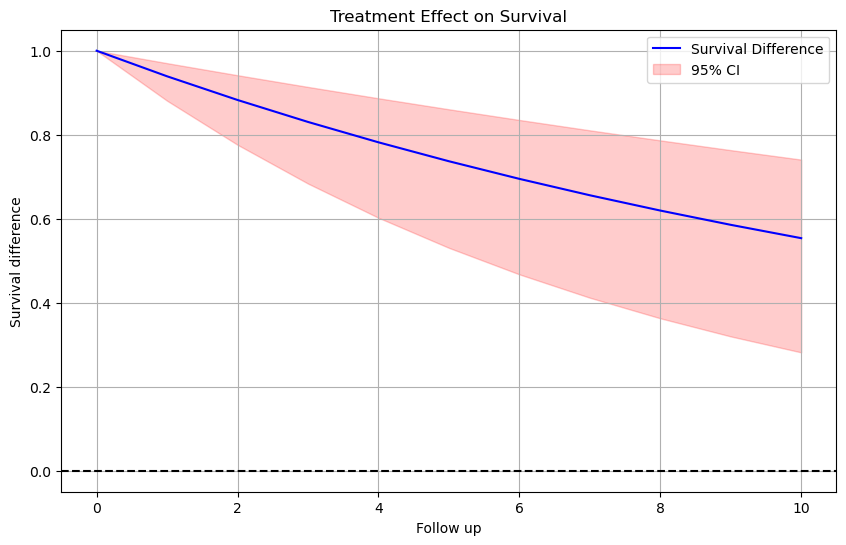

In [11]:
def generate_survival_plot(trial_itt):
    """Generate and save the survival difference plot."""
    # Prepare prediction data
    prediction_data = outcome_data(trial_itt)
    prediction_data = prediction_data[prediction_data['trial_period'] == 1].copy()
    prediction_data['const'] = 1
    
    # Make predictions using the fitted outcome model
    preds = trial_itt.outcome_model.predict(
        data=prediction_data,
        times=list(range(11))
    )
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(preds['times'], 
             preds['survival'].mean(axis=0),  # Average survival across all subjects
             color='blue',
             label='Survival Difference')
    
    # Calculate confidence intervals
    lower = np.percentile(preds['survival'], 2.5, axis=0)
    upper = np.percentile(preds['survival'], 97.5, axis=0)
    
    plt.fill_between(preds['times'],
                     lower,
                     upper,
                     color='red',
                     alpha=0.2,
                     label='95% CI')
    
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel('Follow up')
    plt.ylabel('Survival difference')
    plt.title('Treatment Effect on Survival')
    plt.grid(True)
    plt.legend()
    plt.savefig('survival_difference.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return preds

# Execute prediction and plotting
predictions = generate_survival_plot(trial_itt)

In [12]:
def show_weight_models(trial):
    """Display information about weight models."""
    print("Weight Models Summary:")
    if hasattr(trial, 'switch_weights') and trial.switch_weights is not None:
        print(f"  Switch Weights: {len(trial.switch_weights)} rows")
    if hasattr(trial, 'censor_weights') and trial.censor_weights is not None:
        print(f"  Censor Weights: {len(trial.censor_weights)} rows")
    if hasattr(trial, 'combined_weights') and trial.combined_weights is not None:
        print(f"  Combined Weights: {len(trial.combined_weights)} rows")

def save_to_datatable():
    """Handler for saving expanded data to a data table."""
    def handler(data):
        return data
    return handler

def outcome_data(trial):
    """Extract outcome data from a trial sequence."""
    if trial.expansion is not None:
        return trial.expansion
    return pd.DataFrame()


Data shape: (725, 12)

First few rows:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

Summary statistics:
               id      period   treatment          x1          x2          x3  \
count  725.000000  725.000000  725.000000  725.000000  725.000000  725.000000   
mean    49.278621    7.051034    0.467586    0.405517   -0.173552    0.486897   
std     28.119313    5.802351    0.499293    0.491331    0.997552    0.5

/opt/anaconda3/envs/data_analytics/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/opt/anaconda3/envs/data_analytics/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/envs/data_analytics/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/opt/anaconda3/envs/data_analytics/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common

PP Analysis:
Weight Models Summary:

ITT Analysis:
Weight Models Summary:
  Censor Weights: 725 rows
Trials expanded and models fitted


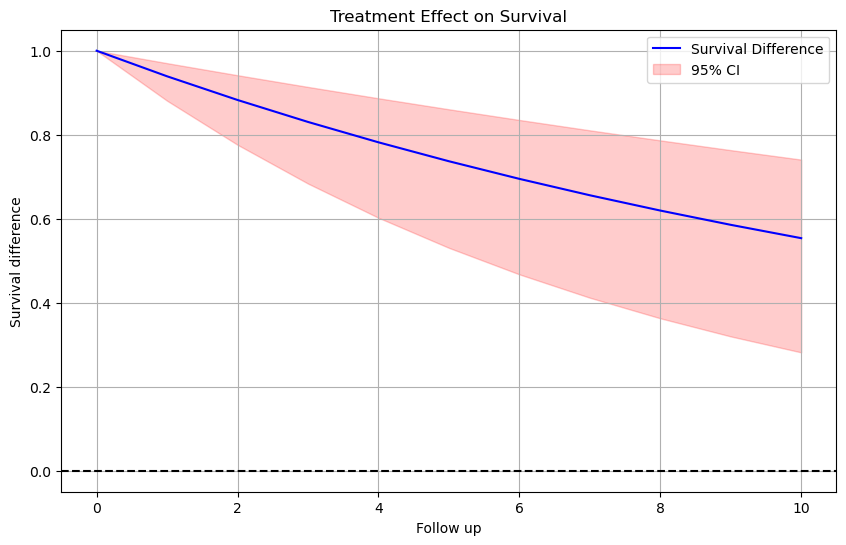

In [13]:
def main():
    """Execute the complete analysis pipeline."""
    # 1. Load data
    data = load_and_prepare_data("data/data_censored.csv")
    
    # 2. Setup trial sequences
    trial_pp, trial_itt, pp_dir, itt_dir = setup_trial_sequences(data)
    
    # 3. Setup weight models
    trial_pp, trial_itt = setup_weight_models(trial_pp, trial_itt, pp_dir, itt_dir)
    
    # 4. Expand trials and fit models
    trial_pp, trial_itt = setup_and_expand_trials(trial_pp, trial_itt)
    
    # 5. Generate predictions and plot
    predictions = generate_survival_plot(trial_itt)
    
    return trial_pp, trial_itt, predictions

# Execute the complete analysis
if __name__ == "__main__":
    trial_pp, trial_itt, predictions = main()